<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/MultilayeredStructures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2018.1.0


#Load pre-defined functions

In [3]:
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py

from DmriFemBuitInFunc import *

class MRI_parameters():
    def __init__(self):
        # Initialize default parameters
        self.bvalue = None
        self.qvalue = None        
        self.gdir = [1, 0, 0];
        self.stype='PGSE'
        self.nperiod = 0; # number of period for OGSE sequences
    def set_gradient_dir(self, mymesh, g0, g1, g2):
        gdim = mymesh.geometry().dim()
        if gdim==2:
            self.gdir = Point(g0, g1)
            self.gdir /= self.gdir.norm()
            self.g = Expression(("g0","g1"), g0=self.gdir.x(), g1=self.gdir.y(),domain=mymesh, degree=1);
        if gdim==3:
            self.gdir = Point(g0, g1, g2)
            self.gdir /= self.gdir.norm()        
            self.g = Expression(("g0","g1","g2"), g0=self.gdir.x(), g1=self.gdir.y(), g2=self.gdir.z(),domain=mymesh, degree=1);
    def time_profile(self, t):
        ft1, ft2 = 0, 0;
        if self.stype=='PGSE':
            ft1 = 1.0*(t>=0 and t<self.delta) 
            ft2 = -1.0*(t>=self.Delta and t<=self.Delta+self.delta);
        if self.stype=='cos_OGSE':
            ft1 =  cos(2.0*self.nperiod*pi*t/self.delta)*(t>=0 and t<self.delta);
            ft2 = -cos(2.0*self.nperiod*pi*(t-2.*self.delta)/self.delta)*(t>=Delta and t<=self.Delta+self.delta);
        return ft1 + ft2; 
    def itime_profile(self, t): 
        # integrate ft
        ft1, ft2, ft3 = 0, 0, 0;
        if self.stype=='PGSE':
            ft1 = t*(t>=0 and t<self.delta) 
            ft2 = self.delta*(t>=self.delta and t<self.Delta) 
            ft3 = (self.delta - t + self.Delta)*(t>=self.Delta and t<=self.Delta+self.delta) 
        if self.stype=='cos_OGSE':
 	          ft1 = 1.0/2.0*self.delta*sin(2.0*t*self.nperiod*pi/self.delta)/self.nperiod/pi * (t >= 0 and  t <= self.delta)
 	          ft2 = 1.0/2.0*self.delta*(sin(2.0*self.Delta*self.nperiod*pi/self.delta)-sin(2.0*t*self.nperiod*pi/self.delta))/nperiod/pi *(t>=self.Delta and t<=self.Delta+self.delta)
        return ft1 + ft2 + ft3;  
    def convert_b2g(self):
        self.gnorm = 0;
        if (self.stype == 'PGSE'):
            self.gnorm = sqrt(self.bvalue)/sqrt(self.delta*self.delta*(self.Delta-self.delta/3.0));
        if (self.stype == 'cos_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        if (self.stype == 'sin_OGSE'):
            self.gnorm = sqrt(self.bvalue/(1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi)));
        return self.gnorm
    def convert_g2b(self):
        self.bvalue = 0;
        if (self.stype == 'PGSE'):
            self.bvalue = self.gnorm*self.gnorm*self.delta*self.delta*(self.Delta-self.delta/3.0);
        if (self.stype == 'cos_OGSE'):
            self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(3.-cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        if (self.stype == 'sin_OGSE'):
	          self.bvalue=self.gnorm*self.gnorm*1./8.*self.delta*self.delta*self.delta*(5.+cos(4.*self.nperiod*pi/self.delta*self.Delta))/(self.nperiod*self.nperiod)/(pi*pi);
        return self.bvalue
      
    def Apply(self):
        self.T = self.Delta+self.delta;
        if not(self.bvalue==None):
            self.gnorm = self.convert_b2g();
            self.qvalue = convert_g2q(self.gnorm);
        elif not(self.qvalue==None):
            self.gnorm = convert_q2g(self.qvalue);
            self.bvalue = self.convert_g2b();
        elif (self.bvalue==None and self.bvalue==None):
            print("bvalue or qvalue need to be specified.")
            sys.exit()      
          
class MRI_simulation():
    def __init__(self):
          self.nskip = 5;    # Output frequency (for visualization only)
          self.theta = 0.5;  # theta=0.5: midpoint method

    def InitialCondition(self, mydomain):
          if mydomain.gdim==2:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          if mydomain.gdim==3:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          Dirac_Delta = interpolate(Dirac_Delta, mydomain.V);
          u_0 = Function(mydomain.W);
          assign(u_0.sub(0), Dirac_Delta)
          if (mydomain.IsDomainMultiple==True):
              assign(u_0.sub(2), Dirac_Delta)  
          return Dirac_Delta, u_0
        
    def solve(self, mydomain, mri_para, linsolver): 
      
          self.Dirac_Delta, self.u_0 = self.InitialCondition(mydomain)
          
          stepcounter = 0;

          M = MassMatrix(mydomain);

          self.t = 0;
          ft_prev  =  mri_para.time_profile(self.t);
          ift_prev = mri_para.itime_profile(self.t);

          start_time = time.time()
          
          while self.t < mri_para.T + self.k: # Time-stepping loop
              if stepcounter % self.nskip == 0:
                  print('t: %f '%self.t, 'T: %.1f'%mri_para.T, 'dt: %.1f'%self.k,'gnorm: %e'%mri_para.gnorm,'Completed %.2f%%'%(float(self.t)/float(mri_para.T+mri_simu.k)*100.0));

              ft = mri_para.time_profile(self.t);
              ift = mri_para.itime_profile(self.t);
              L = ThetaMethodL(ft_prev, ift_prev, mri_para, self, mydomain);
              A = 1/self.k*M + assemble(ThetaMethodF(ft, ift, mri_para, self, mydomain))

              b = assemble(L);
              
              linsolver.solve(A, self.u_0.vector(),b);

              ft_prev  = ft;
              ift_prev = ift;

              self.t += self.k;
              stepcounter += 1;

          elapsed_time = time.time() - start_time
          print("Successfully Completed! Elapsed time: %f seconds"%elapsed_time)

Load pre-defined functions from GitHub


# Working on the mesh and submesh

In [0]:
geo_choice = 2
################################################################################
############## Create two-layered disk using mshr in FEniCS ####################
if geo_choice == 1:
    R1, R2 = 1, 2;
    origin = Point(0.,0.)
    circle = Circle(origin, R1, segments=32)
    domain = Circle(origin, R2, segments=32)
    domain.set_subdomain(1, circle)
    mymesh = generate_mesh(domain, 15) # 15 is the resolution
    cmpt_mesh = generate_mesh(circle, 15)
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    

################################################################################
############## Create multilayered domains using gmsh ##########################
if geo_choice == 2:
    mesh_name = "multi_layered_disk"
    # mesh_name = "multi_layered_cylinder"
    is_partition_function_exist = os.path.isfile('GetPartitionMarkers.py')
    if is_partition_function_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py

    is_geo_file_exist = os.path.isfile(mesh_name+'.geo')  
    if is_geo_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

    # Create mesh from geo file by gmsh
    !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
    
    # Convert .msh to .xml using dolfin-convert
    !dolfin-convert $mesh_name''.msh $mesh_name''.xml
    clear_output()

    mymesh = Mesh(mesh_name+".xml");  

    from GetPartitionMarkers import *

    partion_list=GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

    partition_marker = MeshFunction("size_t", mymesh, mymesh.topology().dim())

    File("pmk_"+mesh_name+".xml")>>partition_marker

    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, None, partition_marker)    

################################################################################
############## Download the existing mesh and submesh ##########################
if geo_choice == 3:
    is_file_exist = os.path.isfile("multi_layer_torus.xml")  
    if is_file_exist==False:
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
        !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
        !unzip -q multi_layer_torus.xml.zip
        !unzip -q multi_layer_torus_compt1.xml.zip
        !rm -rf *.zip *MACOSX

    mymesh = Mesh("multi_layer_torus.xml");  
    cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')
    cellmarker, phase, partition_marker, partion_list = Create_phase_func(mymesh, cmpt_mesh, None)    
    
################################################################################
############## Save, Plot phase functions and submeshes to verify ##############
print("Partition markers:", partion_list)
if mymesh.topology().dim()==2:
    print(cellmarker, partition_marker)
    plt.subplot(1, 2, 1); plot(cellmarker, cmap="coolwarm", title="Cell marker");
    plt.subplot(1, 2, 2); plot(partition_marker, cmap="coolwarm",  title="Partition marker");
mesh0 = SubMesh(mymesh, cellmarker, 0)
mesh1 = SubMesh(mymesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1
plt.figure(2); plot(mesh0, title="Compartment 0") 
plt.figure(3); plot(mesh1, title="Compartment 1")

Extracting cell markers from: multi_layered_disk.msh ...
Extracted successfully on: 1446 elements
Partition marker list: ['0', '1', '2', '3']
Wrote to: pmk_multi_layered_disk.xml
Partition markers: [0, 1, 2, 3]
<dolfin.cpp.mesh.MeshFunctionSizet object at 0x7f38c73091f0> <dolfin.cpp.mesh.MeshFunctionSizet object at 0x7f38c72a1030>


# Solve the Bloch-Torrey equation

In [6]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                # sequence type
mri_para.bvalue = 1000;                              # bvalue
mri_para.delta, mri_para.Delta = 10000, 10000        # time sequence
mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction
mri_para.Apply()
mri_simu.k = 400;                                    # time-step size
mri_simu.nskip = 1;                                  # frequency to print ouputs

mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = phase
mydomain.PeriodicDir = [1, 0, 0];            # Direction of the periodicity
mydomain.IsDomainPeriodic = True             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = True             # Confirm if the mesh is multiple
mydomain.kappa = 1e-1                        # Permeability
################################################################################

mydomain.Apply()   # Call Apply before setting the diffusion tensor

################################################################################
# Impose the diffusion coefficient
D0 = 3e-3

# Impose diffusion coefficient
mydomain.D = D0;

############### Impose the diffusion tensor
# Constant tensor
# d00, d01, d02, d10, d11, d12, d20, d21, d22 = D0, 0, 0, 0, D0, 0, 0, 0, D0

# Variable tensor
#dofmap_DG = mydomain.V_DG.dofmap()
#d00 = Function(mydomain.V_DG); d01 = Function(mydomain.V_DG); d02 = Function(mydomain.V_DG)
#d10 = Function(mydomain.V_DG); d11 = Function(mydomain.V_DG); d12 = Function(mydomain.V_DG)
#d20 = Function(mydomain.V_DG); d21 = Function(mydomain.V_DG); d22 = Function(mydomain.V_DG)

#for cell in cells(mymesh):
#    p = cell.midpoint() # the coordinate of the cell center.
#    d00.vector()[dofmap_DG.cell_dofs(cell.index())] = D0
#    d11.vector()[dofmap_DG.cell_dofs(cell.index())] = D0
#    d22.vector()[dofmap_DG.cell_dofs(cell.index())] = D0

#mydomain.ImposeDiffusionTensor(d00, d01, d02, d10, d11, d12, d20, d21, d22)
#################################################################################
#################################################################################


mri_simu.solve(mydomain, mri_para, PETScLUSolver("mumps"))

Function Space for Two-compartment Domains has 4 components
(ur0, ui0, ur1, ur1): r-real, i-imaginary
Initialize peridodic function spaces.
The pseudo-periodic BCS are strongly imposed.
The mesh needs to be periodic.
t: 0.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 0.00%
t: 400.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 1.96%
t: 800.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 3.92%
t: 1200.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 5.88%
t: 1600.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 7.84%
t: 2000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 9.80%
t: 2400.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 11.76%
t: 2800.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 13.73%
t: 3200.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 15.69%
t: 3600.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 17.65%
t: 4000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-

#Post-processing

Signal on each compartment
Signal0: 3.147e-01
Signal1: 3.148e-01
b: 1000 Signal: 3.147e-01 kappa: 1.000e-01 , dt:  400 , hmin:  0.14255291546690105 , Free signal: 4.979e-02


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


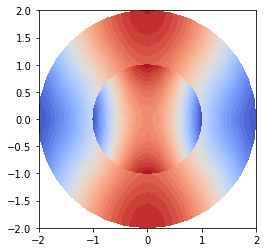

In [7]:
if mydomain.IsDomainMultiple == True:
    u0r_0, u0i_0, u1r_0, u1i_0 = split(mri_simu.u_0)
    signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx)/assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
    signal1 = assemble((mydomain.phase*u1r_0)*dx)/assemble(mydomain.phase*mri_simu.Dirac_Delta*dx);
    signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('Signal on each compartment')
    print('Signal0: %.3e'%signal0)
    print('Signal1: %.3e'%signal1)
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%mydomain.kappa,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V0 = FunctionSpace(mesh0, mydomain.Ve);
    V1 = FunctionSpace(mesh1, mydomain.Ve);
    u0r_0p = project(u0r_0,V0)
    u1r_0p = project(u1r_0,V1)
    plot(u0r_0p, cmap="coolwarm")
    plot(u1r_0p, cmap="coolwarm")  
else:
    ur, ui = split(mri_simu.u_0)
    signal = assemble(ur*dx)/assemble(mri_simu.Dirac_Delta*dx);
    print('b:',mri_para.bvalue, 'Signal: %.3e'%signal,', dt: ',mri_simu.k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mri_para.bvalue*D0)))
    V = FunctionSpace(mymesh,mydomain.Ve);
    ur_p = project(ur,V)
    plot(ur_p, cmap="coolwarm")



# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # R=[5,7.5,10], kappa=5e-5m/s delta=Delta=40000
#  bvalue  # signal attenuation
# # # # # # # # # # # # # # #
# # # # # # # # # # # # # # #